# Measuring source to target domain shifts

## Notebook setup

In [1]:
#| code-fold: true
#| code-summary: "Click to see packages imported"
import os
import configparser
import random
import shutil
from pathlib import Path

import torch
import wfdb
import numpy as np
import pandas as pd

In [2]:
#|include: false
# If the current working directory is the nbs/ folder, change to the project 
# root directory instead.
if Path.cwd().stem == "nbs":
    os.chdir(Path.cwd().parent)
print(f"The current working directory is {Path.cwd()}")

The current working directory is c:\Users\Shaun\source\Thesis\MisdiagnosisOfAthleteECG


In [3]:
from src.data.util import get_all_records, codes_to_label_vector, get_predicted_findings
from src.data.challenge2020 import extract_snomed_ct_codes_from_comment
import src.data.norwegian as norwegian

In [4]:
#|include: false
# Import configuration settings, like location of data directory.
config = configparser.ConfigParser()
if not Path("config.ini").exists():
    print("WARNING: Please generate a config.ini file by running scripts/get_datasets.py")
else:
    config.read("config.ini")
    data_dir = Path((config["datasets"]["path"])).expanduser()
    print(f"Datasets are located at {data_dir.resolve()}")

Datasets are located at C:\Users\Shaun\source\Thesis\MisdiagnosisOfAthleteECG\data


In [75]:
athlete_dataset_dir = data_dir / "norwegian-athlete-ecg" / "1.0.0"
pf12red_dataset_dir = data_dir / "pf12red" / "extracted_NSR"

In [18]:
# Path to each training dataset

training_dir = data_dir / "challenge-2020" / "1.0.2" / "training"

georgia_dir = training_dir / "georgia"
cpsc_dir = training_dir / "cpsc_2018"
cpscextra_dir = training_dir / "cpsc_2018_extra"
ptb_dir = training_dir / "ptb"
ptbxl_dir = training_dir / "ptb-xl"
incart_dir = training_dir / "st_petersburg_incart"

training_datasets = [georgia_dir, cpsc_dir, cpscextra_dir, ptbxl_dir]

## Label distribution

In [5]:
sinus_labels = [426177001, 426783006, 427084000, 427393009]
# sinus_labels = [426177001, 426783006]       # Bradycardia or Normal
rbbb_labels = [713427006, 713426002]        # Incomplete RBBB, Complete RBBB
# won't do t-wave inversion, because no output for lead number provided.
athlete_labels = sinus_labels + rbbb_labels

In [27]:
def count_labels_in_dataset(dataset_dir: Path, athlete_labels: list) -> list:
    label_prevalence = [0 for i in range(len(athlete_labels))]

    for entry in get_all_records(dataset_dir):
        # record = wfdb.rdrecord(entry)
        if dataset_dir == data_dir / "norwegian-athlete-ecg" / "1.0.0":
            record = wfdb.rdrecord(dataset_dir / entry)     # Hack, don't want to fix get_all_records() now
            # Actual finding labels (norwegian dataset only)
            comments_c = record.comments[1]
            findings_c = norwegian.extract_findings(comments_c)
            actual_findings = norwegian.classify_relevant_findings(findings_c)
            actual_labels = codes_to_label_vector(actual_findings, athlete_labels)
        else:
            record = wfdb.rdrecord(entry)
            # Actual finding labels
            if record.comments[2] == 'Dx:':
                finding_codes = []
            else:
                finding_codes = extract_snomed_ct_codes_from_comment(record.comments[2])
            actual_labels = codes_to_label_vector(finding_codes, athlete_labels)
        
        # Sum
        for i in range(len(actual_labels)):
            label_prevalence[i] += actual_labels[i]
    return label_prevalence


In [28]:
label_distribution_athletic = count_labels_in_dataset(athlete_dataset_dir, athlete_labels)
label_distribution_athletic

[5, 17, 0, 7, 0, 2]

In [26]:
label_distribution_general = [0 for i in range(len(athlete_labels))]
for dataset_dir in training_datasets:
    print(dataset_dir)
    for i, n in enumerate(count_labels_in_dataset(dataset_dir, athlete_labels)):
        label_distribution_general[i] += n

data\challenge-2020\1.0.2\training\georgia
data\challenge-2020\1.0.2\training\cpsc_2018
data\challenge-2020\1.0.2\training\cpsc_2018_extra
data\challenge-2020\1.0.2\training\ptb-xl


In [29]:
label_distribution_general

[2332, 20282, 2366, 1217, 674, 1590]

In [30]:
from scipy.special import rel_entr

In [40]:
P = [x/sum(label_distribution_general) for x in label_distribution_general]
Q = [x/sum(label_distribution_athletic) for x in label_distribution_athletic]

In [ ]:
# Hack: All values need to be non-zero
Q[2] += np.finfo(float).eps
Q[4] += np.finfo(float).eps
Q

[0.16129032258064516,
 0.5483870967741935,
 2.220446049250313e-16,
 0.22580645161290322,
 2.220446049250313e-16,
 0.06451612903225806]

In [42]:
rel_entr(P,Q)

array([-0.05549237,  0.18668827,  2.78958054, -0.07115603,  0.76492745,
       -0.0080425 ])

In [43]:
rel_entr(Q,P)

array([ 1.09235350e-01, -1.43662572e-01, -7.45099969e-15,  3.75757484e-01,
       -7.17217252e-15,  9.28778638e-03])

In [ ]:
print('KL(P || Q): %.3f nats' % sum(rel_entr(P,Q)))
print('KL(Q || P): %.3f nats' % sum(rel_entr(Q,P)))
# Nats instead of Bits, because scipy uses natural log, not log-2

KL(P || Q): 3.607 nats
KL(Q || P): 0.351 nats


## Age distribution (continuous?)

In [45]:
from src.data.challenge2020 import generate_labels_table

In [81]:
georgia_df = generate_labels_table(get_all_records(georgia_dir))
cpsc_df = generate_labels_table(get_all_records(cpsc_dir))
cpscextra_df = generate_labels_table(get_all_records(cpscextra_dir))
ptbxl_df = generate_labels_table(get_all_records(ptbxl_dir))

In [83]:
georgia_df.age.head()

0     NaN
1     NaN
2     NaN
3    75.0
4    83.0
Name: age, dtype: float64

In [89]:
# Count ages in training datasets
general_ages = []
general_ages += georgia_df.age.to_list()
general_ages += cpsc_df.age.to_list()
general_ages += cpscextra_df.age.to_list()
general_ages += ptbxl_df.age.to_list()

In [90]:
len(general_ages)

40753

In [79]:
# Count ages in pf12red athlete dataset (raw demographic data not available for norwegian)
athlete_ages = []
for entry in get_all_records(pf12red_dataset_dir):
    record = wfdb.rdrecord(pf12red_dataset_dir / entry)     # Hack, don't want to fix get_all_records() now
    age = float( record.comments[0].split(": ")[1] )
    athlete_ages.append(age)

### Binning process

In [ ]:
# Remove paediatric cases. Either below 18 (UK) or below 21 (US).
# Remove obvious outlier ages. HIPAA guidelines say to remove ages over 89.
bin_edges = np.linspace(15, 90, 16)
bin_edges

array([15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70., 75.,
       80., 85., 90.])

In [69]:
bin_indices = np.digitize(georgia_df.age.to_list(), bin_edges)
bin_indices

array([16, 16, 16, ...,  5, 10, 12], dtype=int64)

In [68]:
hist = np.bincount(bin_indices)
hist

array([   0,    7,  203,  206,  284,  386,  576,  708,  956, 1066, 1265,
       1431, 1245,  908,  608,  406,   77], dtype=int64)

In [91]:
def bin_ages(age_list: list):
    # Remove paediatric cases. Either below 18 (UK) or below 21 (US).
    # Remove obvious outlier ages. HIPAA guidelines say to remove ages over 89.
    bin_edges = np.linspace(15, 90, 16)
    bin_indices = np.digitize(age_list, bin_edges)
    hist = np.bincount(bin_indices)
    return hist

### Divergence

In [104]:
age_distribution_general = bin_ages(general_ages)
age_distribution_athletic = bin_ages(athlete_ages)

# Hack: Fill in older age bins for athletic domain
while len(age_distribution_athletic) < len(age_distribution_general):
    age_distribution_athletic = np.append(age_distribution_athletic, 0)

In [105]:
age_distribution_general

array([   0,  375,  750, 1081, 1228, 1519, 1974, 2601, 3631, 4202, 4915,
       5240, 4474, 3860, 2990, 1736,  177], dtype=int64)

In [106]:
age_distribution_athletic

array([ 0, 18, 51, 38, 32,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

In [115]:
P = [x/sum(age_distribution_general) for x in age_distribution_general]
Q = [x/sum(age_distribution_athletic) for x in age_distribution_athletic]

# Hack: make sure no value is 0
P[0] += np.finfo(float).eps
for i, value in enumerate(Q):
    if value == 0:
        Q[i] += np.finfo(float).eps

In [116]:
P

[2.220446049250313e-16,
 0.009201776556327142,
 0.018403553112654285,
 0.02652565455303904,
 0.03013275096311928,
 0.03727332957082914,
 0.04843815179250607,
 0.06382352219468505,
 0.0890977351360636,
 0.10310897357249774,
 0.12060461806492774,
 0.12857949108041125,
 0.10978332883468701,
 0.09471695335312738,
 0.0733688317424484,
 0.04259809093809045,
 0.004343238534586411]

In [111]:
Q

[2.220446049250313e-16,
 0.1258741258741259,
 0.35664335664335667,
 0.26573426573426573,
 0.22377622377622378,
 0.027972027972027972,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16,
 2.220446049250313e-16]

In [117]:
print('KL(P || Q): %.3f nats' % sum(rel_entr(P,Q)))
print('KL(Q || P): %.3f nats' % sum(rel_entr(Q,P)))
# Nats instead of Bits, because scipy uses natural log, not log-2

KL(P || Q): 29.367 nats
KL(Q || P): 2.439 nats


## Distribution plots

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
len(bin_edges)

16

In [138]:
len(bin_edges[0:len(bin_edges)-1])

15

In [123]:
len(P)

17

In [142]:
bin_edges[:-1]

array([15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70., 75.,
       80., 85.])

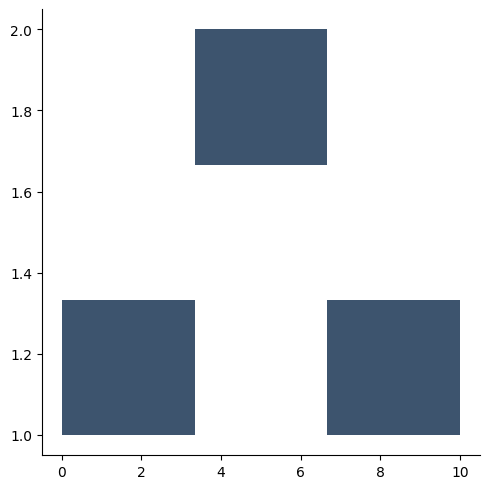

In [147]:
sns.displot(x=[0,5,10], y=[1,2,1])

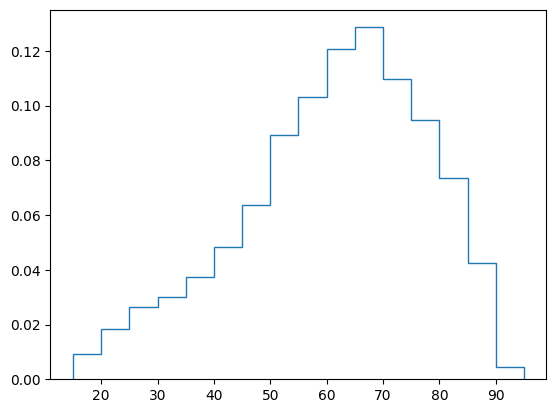

In [ ]:
plt.stairs(values=P[1:], edges=[15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])

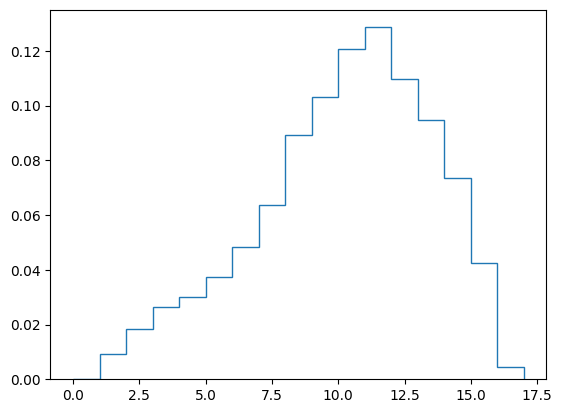

In [141]:
plt.stairs(values=P)

In [124]:
plt.stairs?

Signature:
plt.stairs(
    values: 'ArrayLike',
    edges: 'ArrayLike | None' = None,
    *,
    orientation: "Literal['vertical', 'horizontal']" = 'vertical',
    baseline: 'float | ArrayLike | None' = 0,
    fill: 'bool' = False,
    data=None,
    **kwargs,
) -> 'StepPatch'
Docstring:
Draw a stepwise constant function as a line or a filled plot.

*edges* define the x-axis positions of the steps. *values* the function values
between these steps. Depending on *fill*, the function is drawn either as a
continuous line with vertical segments at the edges, or as a filled area.

Parameters
----------
values : array-like
    The step heights.

edges : array-like
    The step positions, with ``len(edges) == len(vals) + 1``,
    between which the curve takes on vals values.

orientation : {'vertical', 'horizontal'}, default: 'vertical'
    The direction of the steps. Vertical means that *values* are along
    the y-axis, and edges are along the x-axis.

baseline : float, array-like or None, d